In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
NUM_STATS = K+D*K
NUM_LATENTS = D * K
NUM_OBS = D + K
BATCH_SIZE = 10
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-4
CUDA = False

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
covs = torch.from_numpy(np.load('gmm_dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Zs.shape[0]

In [4]:
def StatsGMM(Xs, Zs, K, D):
    """
    Xs is B * N * D
    Zs is B * N * K
    return B * (K+D*K)
    """
    stat1 = Zs.sum(1)
    stat2 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    return stat1, stat2, torch.cat((stat1, stat2.view(-1, D*K)), dim=-1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats+K*D, num_hidden),
            nn.ReLU())
        self.mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, covs, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        stats_covs = torch.cat((stats, covs.view(-1, K*D)), dim=-1)

        hidden = self.enc_hidden(stats_covs)
        mean = self.mean(hidden).view(-1, K, D)
        std = torch.exp(self.log_std(hidden).view(-1, K, D))
        mus = Normal(mean, std).sample((num_samples, )) ## S * B * K * D
        return mean, std, mus

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
def log_joints_gmm(Z, Pi, mus, covs, Xs, N, D, K, num_samples, batch_size):
    log_probs = torch.zeros((num_samples, batch_size)).float()
    ## S * B
    log_probs = log_probs + Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D))).log_prob(mus).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    covs_expand = covs.unsqueeze(0).repeat(num_samples, 1, 1, 1)
    log_probs = log_probs + Normal(mus[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D), covs_expand[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D)).log_prob(Xs).sum(-1).sum(-1)
    return log_probs

def conjugate_posterior(stat1, stat2, covs, K, D, batch_size):
    prior_covs_inv = torch.ones(K, D)
    posterior_covs = 1. / (prior_covs_inv + torch.mul(stat1.unsqueeze(-1).repeat(1, 1, D), 1. / covs))
    posterior_mean = torch.mul(posterior_covs, torch.mul(stat2, 1. / covs))
    return posterior_mean, posterior_covs

def kl_normal_normal(p_mean, p_std, q_mean, q_std):
    var_ratio = (p_std / q_std).pow(2)
    t1 = ((p_mean - q_mean) / q_std).pow(2)
    return 0.5 * (var_ratio + t1 - 1 - var_ratio.log())

def kls_gaussians(weights, mus, mus_mean, mus_std, posterior_mean, posterior_covs, K, D):
    log_q = Normal(mus_mean, mus_std).log_prob(mus).sum(-1).sum(-1)
    log_p = Normal(posterior_mean, torch.sqrt(posterior_covs)).log_prob(mus).sum(-1).sum(-1)
    MCKl_exclusive = (log_q - log_p).mean(0).mean()
    TrueKl_exclusive = kl_normal_normal(mus_mean, mus_std, posterior_mean, torch.sqrt(posterior_covs)).mean()
    
    MCKl_inclusive = torch.mul(weights, log_p - log_q).sum(0).mean()
    TrueKl_inclusive = kl_normal_normal(posterior_mean, torch.sqrt(posterior_covs), mus_mean, mus_std).mean()
    return MCKl_inclusive, TrueKl_inclusive, MCKl_exclusive, TrueKl_exclusive
    
def rws(Xs, Zs, Pi, covs, N, K, D, num_samples, batch_size):
    stat1, stat2, stats = StatsGMM(Xs, Zs, K, D)
    data = torch.cat((Xs, Zs), dim=-1).view(batch_size*N, -1)
    mus_mean, mus_std, mus = enc(data, K, D, covs, num_samples, batch_size)
    log_q = Normal(mus_mean, mus_std).log_prob(mus).sum(-1).sum(-1) ## S * B
#     print(log_q.sum())
    log_p = log_joints_gmm(Zs, Pi, mus, covs, Xs, N, D, K, num_samples, batch_size)
    log_weights = log_p - log_q
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
    posterior_mean, posterior_covs = conjugate_posterior(stat1, stat2, covs, K, D, batch_size)
    MCKl_inclusive, TrueKl_inclusive, MCKl_exclusive, TrueKl_exclusive = kls_gaussians(weights, mus, mus_mean, mus_std, posterior_mean, posterior_covs, K, D)
    return eubo, elbo, ess, MCKl_inclusive, TrueKl_inclusive, MCKl_exclusive, TrueKl_exclusive

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

In [8]:
EUBOs = []
ELBOs = []
ESSs = []
MCKls_inclusive = []
TrueKls_inclusive = []
MCKls_exclusive = []
TrueKls_exclusive = []

num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)

    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    MCKl_inclusive = 0.0
    TrueKl_inclusive = 0.0
    MCKl_exclusive = 0.0
    TrueKl_exclusive = 0.0
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs[batch_indices]
        batch_Covs = covs[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, mckl_inclusive, truekl_inclusive, mckl_exclusive, truekl_exclusive = rws(batch_Xs, batch_Zs, Pi, batch_Covs, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        MCKl_inclusive += mckl_inclusive.item()
        MCKl_exclusive += mckl_exclusive.item()
        TrueKl_inclusive += truekl_inclusive.item()
        TrueKl_exclusive += truekl_exclusive.item()
        
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    MCKl_inclusive /= num_batches
    TrueKl_inclusive /= num_batches
    MCKl_exclusive /= num_batches
    TrueKl_exclusive /= num_batches
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    MCKls_inclusive.append(MCKl_inclusive)
    TrueKls_inclusive.append(TrueKl_inclusive)
    MCKls_exclusive.append(MCKl_exclusive)
    TrueKls_exclusive.append(TrueKl_exclusive)
    
#     time_end = time.time()
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f, inc MCKL=%f, inc TKL=%f, exc MCKL=%f, exc TKL=%f (%ds)' % (epoch, EUBO, ELBO, ESS, MCKl_inclusive, TrueKl_inclusive, MCKl_exclusive, TrueKl_exclusive, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-1271.378892, ELBO=-10855.930715, ESS=1.024, inc MCKL=-764.879894, inc TKL=1584884.341302, exc MCKL=6911.109434, exc TKL=1273.031786 (0s)
epoch=10, EUBO=-687.386860, ELBO=-1178.635984, ESS=1.026, inc MCKL=-365.834610, inc TKL=159.639456, exc MCKL=668.876913, exc TKL=111.668575 (5s)
epoch=20, EUBO=-504.084548, ELBO=-1115.850875, ESS=1.014, inc MCKL=-260.714007, inc TKL=8.323487, exc MCKL=631.149735, exc TKL=104.544471 (5s)
epoch=30, EUBO=-482.861935, ELBO=-1002.508594, ESS=1.019, inc MCKL=-238.615424, inc TKL=7.942472, exc MCKL=552.473694, exc TKL=91.998437 (5s)
epoch=40, EUBO=-465.949550, ELBO=-941.764814, ESS=1.027, inc MCKL=-226.490879, inc TKL=5.540313, exc MCKL=516.689613, exc TKL=86.885913 (5s)
epoch=50, EUBO=-449.015325, ELBO=-904.812898, ESS=1.027, inc MCKL=-215.900273, inc TKL=5.168196, exc MCKL=497.753257, exc TKL=84.432206 (5s)
epoch=60, EUBO=-431.965674, ELBO=-887.232361, ESS=1.021, inc MCKL=-204.661038, inc TKL=4.472894, exc MCKL=479.579182, exc TKL=79.486120 

KeyboardInterrupt: 

In [9]:
def plot_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(30, 30))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax2.plot(TrueKls_exclusive, '#66b3ff', label='true exclusive KL')
    ax2.plot(MCKls_exclusive, '#ff9999', label='est exclusive KL')
    ax2.plot(TrueKls_inclusive, '#99ff99', label='true inclusive KL')
    ax2.plot(MCKls_inclusive, 'gold', label='est inclusive KL')
    
    ax1.tick_params(labelsize=18)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-300, -80])
    ax1.legend()
    ax2.set_ylim([-50, 50])
    ax2.legend()
    ax3.legend()
    ax2.tick_params(labelsize=18)
    ax3.tick_params(labelsize=18)
    plt.savefig('encode_stats_sigmas_lr=%.1E_samples=%d.svg' % (lr, num_samples))

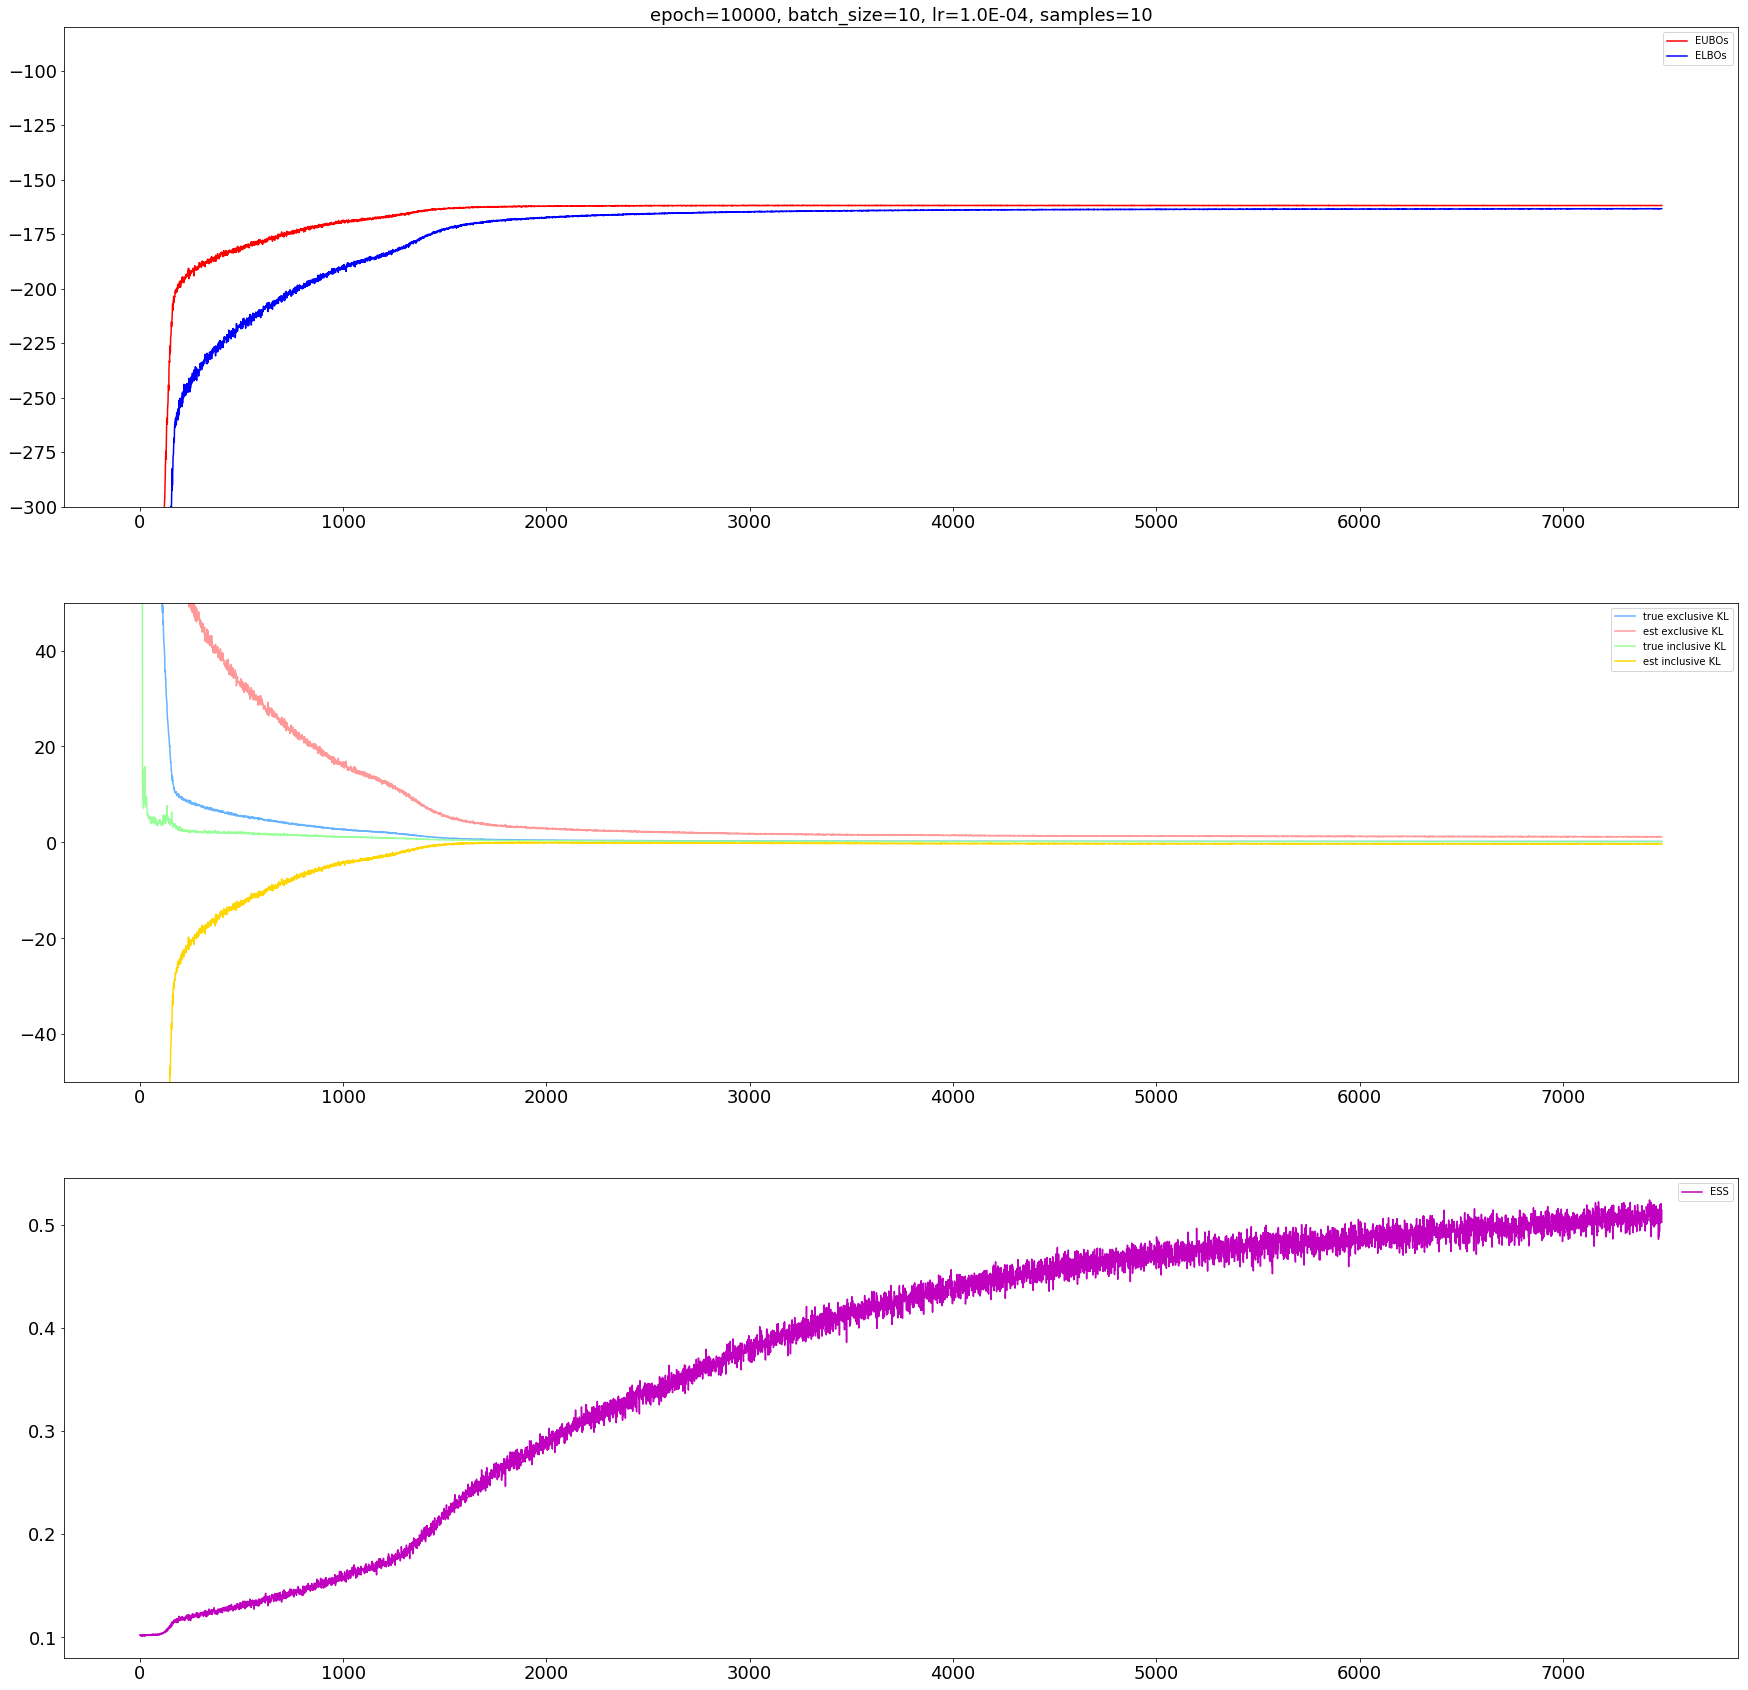

In [10]:
plot_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [14]:
BATCH_SIZE = 50

indices = torch.randperm(num_seqs)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
batch_Xs = Xs[batch_indices]
batch_Zs = Zs[batch_indices]
batch_Covs = covs[batch_indices]
batch_Mus = mus_true[batch_indices]
batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)

data = torch.cat((batch_Xs, batch_Zs), dim=-1).view(BATCH_SIZE*N, -1)
mus_mean, mus_std, mus = enc(data, K, D, batch_Covs, 10, BATCH_SIZE)

In [17]:
def plot_predictions(Xs, mus_true1, covs_true1, mus_pred):
    Xs = Xs.data.numpy()
    mus_true1 = mus_true1.data.numpy()
    covs_true1 = covs_true1.data.numpy()
    
    fig = plt.figure(figsize=(40, 80))
    for i in range(10):
        for j in range(5):
            batch_covs_expand = torch.zeros((K, D, D))
            for k in range(K):
                batch_covs_expand[k] = torch.diag(batch_Covs[i*5+j][k])
            mus_flat = mus_pred[:, i*5+j].contiguous().view(10*K, D).data.numpy()
            ax = fig.add_subplot(10, 5, i*5+j+1)
            ax.plot(Xs[i*5+j][:,0], Xs[i*5+j][:,1], 'ro')
            ax.plot(mus_flat[:, 0], mus_flat[:, 1], 'ko')
            ax.set_xticks([])
            ax.set_yticks([])
            plot_cov_ellipse(cov=batch_covs_expand[0], pos=mus_true1[i*5+j, 0], nstd=2, ax=ax, alpha=0.5)
            plot_cov_ellipse(cov=batch_covs_expand[1], pos=mus_true1[i*5+j, 1], nstd=2, ax=ax, alpha=0.5)
            plot_cov_ellipse(cov=batch_covs_expand[2], pos=mus_true1[i*5+j, 2], nstd=2, ax=ax, alpha=0.5)
            ax.set_ylim([-10, 10])
            ax.set_xlim([-10, 10])
    plt.tight_layout()
    plt.savefig('encode_stats_sigmas_predictions_only_learn_mus.svg')
#     plt.show()

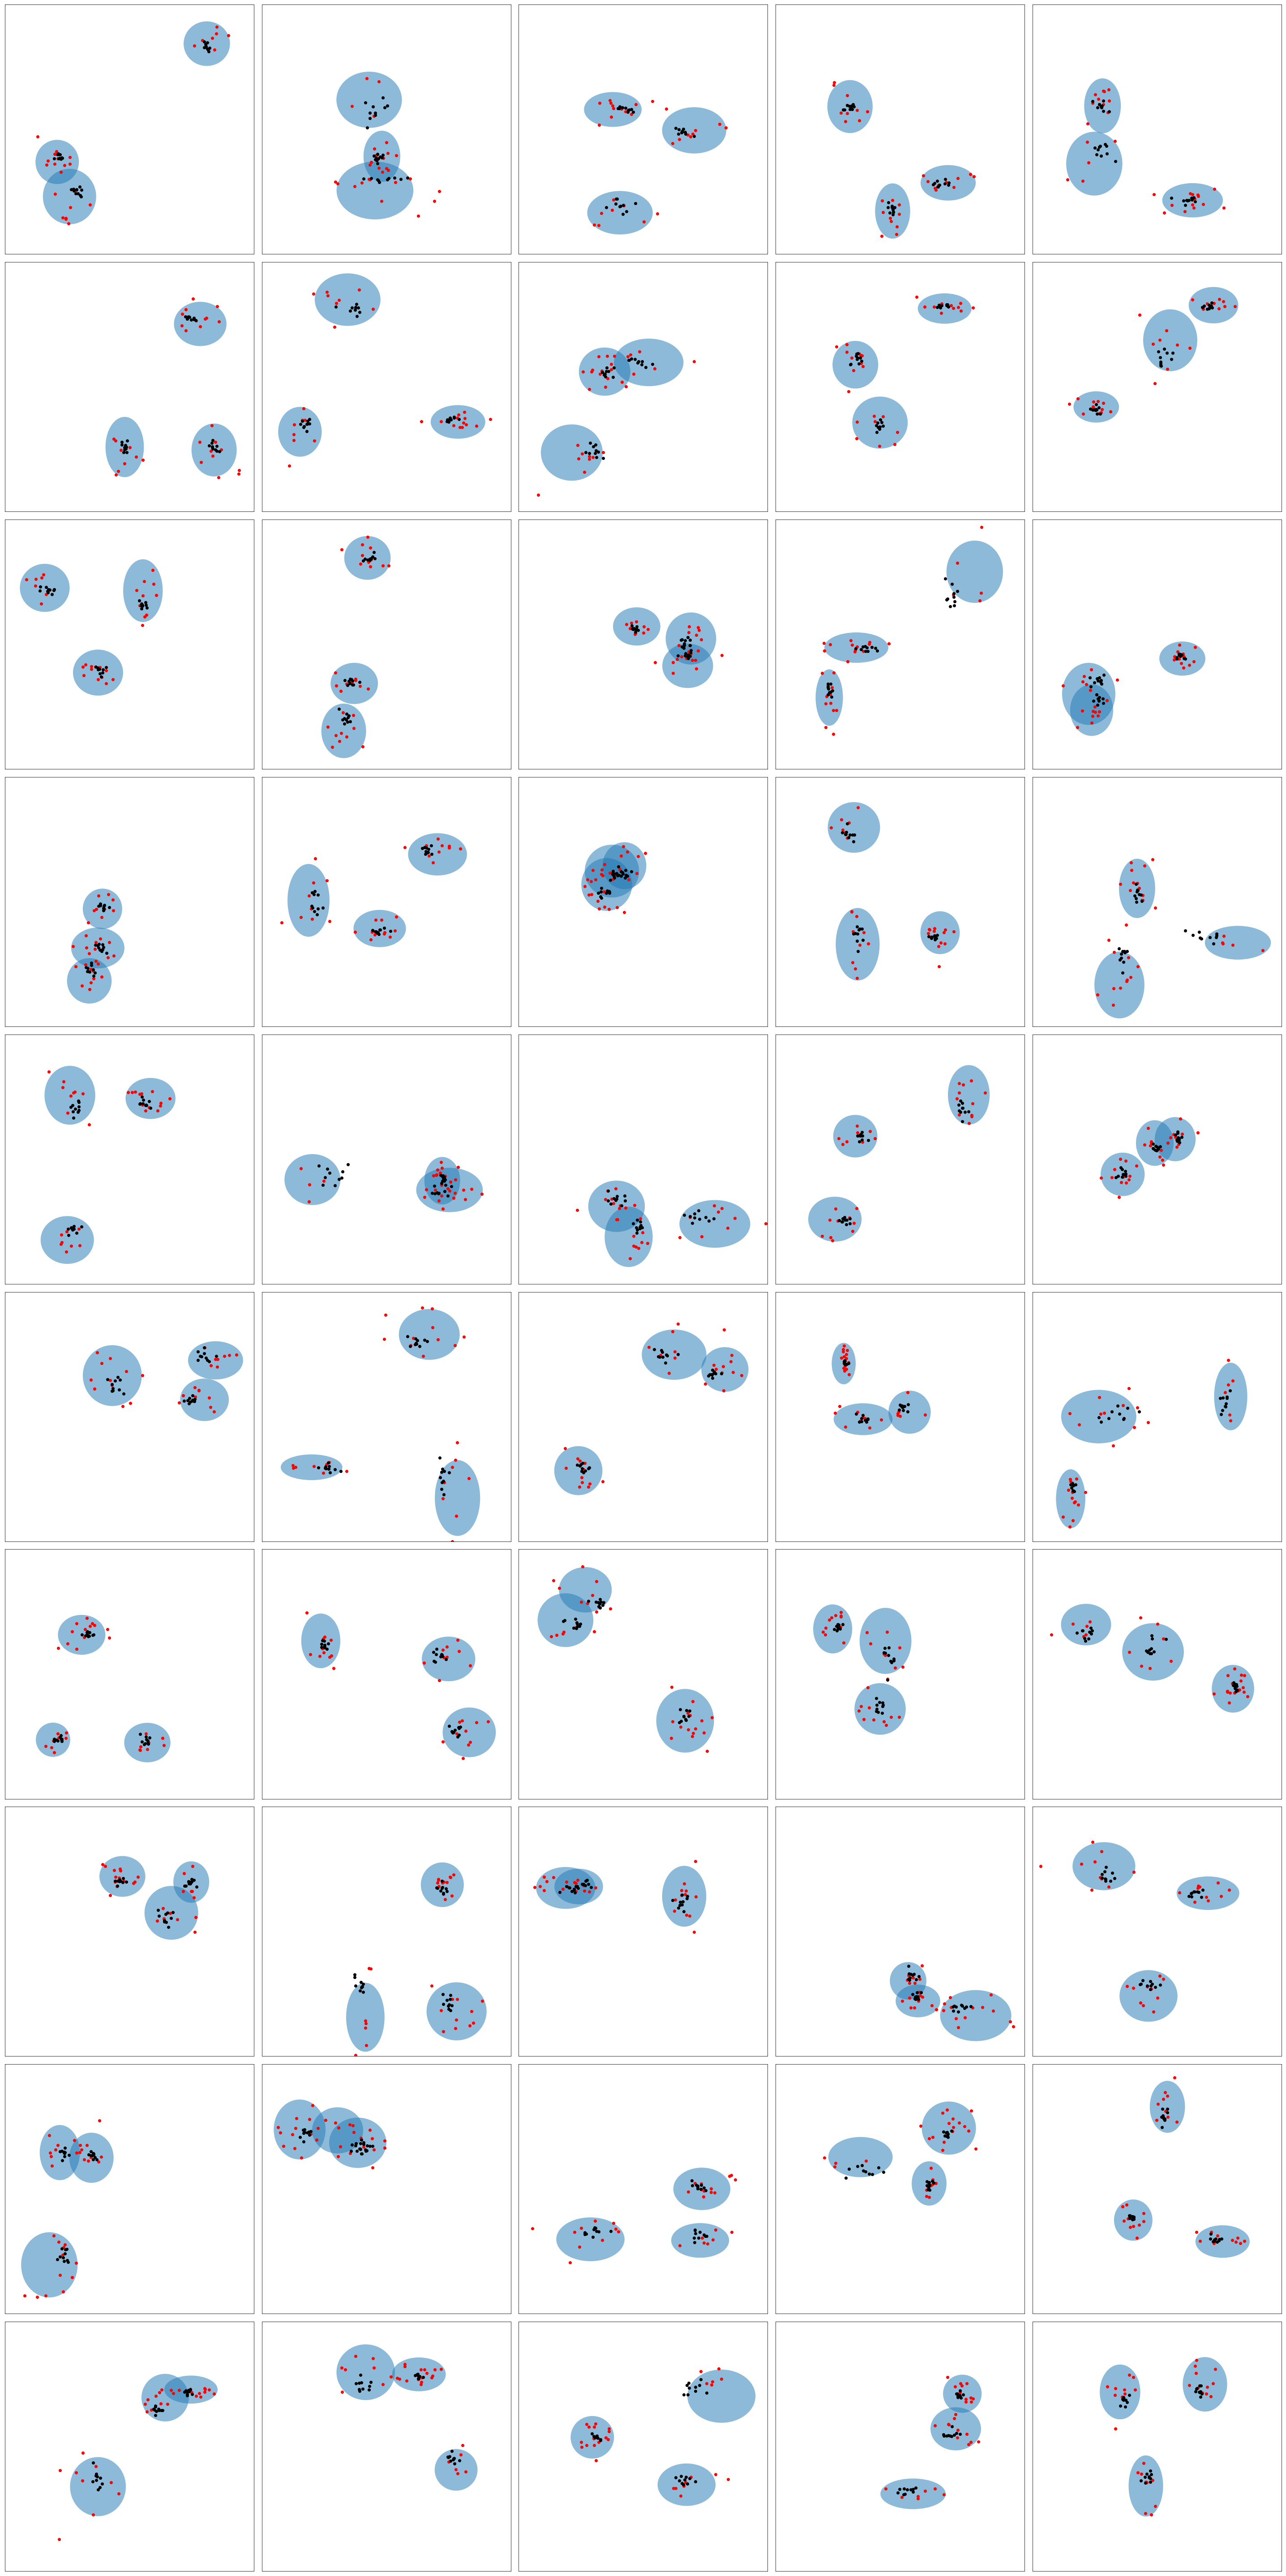

In [18]:
plot_predictions(batch_Xs, batch_Mus, batch_Covs, mus)

In [19]:
torch.save(enc.state_dict(), 'models/enc-encode_stats_sigmas-only-learn-mus-samples=10-iters=1e6-lr=1e-4')

In [21]:
def save_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE):
    fout = open('encode_stats_sigmas_only_learn_mus_samples=%d_epochs=%d_lr=%1e-4.txt', 'w+')
    fout.write('EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) + ', ' + str(MCKls_exclusive[i]) + ', ' + str(TrueKls_exclusive[i]) + ', ' + str(MCKls_inclusive[i]) + ', ' + str(TrueKls_inclusive[i]) + '\n')
    fout.close()

In [22]:
save_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [3]:


fin = open('results/OneShotEncoder_only_learn_mus_samples=%d_epochs=%d_lr=%1e-4.txt')
EUBOs0 = []
ELBOs0 = []
ESSs0 = []
MCKl_exclusive0 = []
MCKl_inclusive0 = []
TrueKl_exclusive0 = []
TrueKl_inclusive0 = []

for line in fin.readlines():
    line = line.strip().split(', ')
    if line[0] != 'EUBOs':
        EUBOs0.append(float(line[0]))
        ELBOs0.append(float(line[1]))
        ESSs0.append(float(line[2]))
        MCKl_exclusive0.append(line[3])
        TrueKl_exclusive0.append(line[4])
        MCKl_inclusive0.append(line[5])
        TrueKl_inclusive0.append(line[6])
fin.close()


fin2 = open('results/encode_stats_sigmas_only_learn_mus_samples=%d_epochs=%d_lr=%1e-4.txt')
EUBOs = []
ELBOs = []
ESSs = []
MCKl_exclusive = []
MCKl_inclusive = []
TrueKl_exclusive = []
TrueKl_inclusive = []

for line in fin2.readlines():
    line = line.strip().split(', ')
    if line[0] != 'EUBOs':
        EUBOs.append(float(line[0]))
        ELBOs.append(float(line[1]))
        ESSs.append(float(line[2]))
        MCKl_exclusive.append(line[3])
        TrueKl_exclusive.append(line[4])
        MCKl_inclusive.append(line[5])
        TrueKl_inclusive.append(line[6])
fin2.close()


In [ ]:
fig = plt.figure(figsize=(30, 30))
fig.tight_layout()
ax1 = fig.add_subplot(2, 1, 1)
ax3 = fig.add_subplot(2, 1, 2)
ax1.plot(EUBOs, 'r', label='EUBOs -- encode sigmas')
ax1.plot(ELBOs, 'b', label='ELBOs -- encode sigmas')
ax1.plot(EUBOs0, 'g', label='EUBOs ')
ax1.plot(ELBOs0, 'k', label='ELBOs')


ax1.tick_params(labelsize=18)
# ax3.plot(np.array(ESSs) / NUM_SAMPLES, 'm', label='ESS -- encode sigmas')
# ax3.plot(np.array(ESSs0) / NUM_SAMPLES, 'k', label='ESS')

ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, NUM_SAMPLES), fontsize=18)
ax1.set_ylim([-300, -80])
ax1.legend()
# ax3.legend()
# ax3.tick_params(labelsize=18)
# plt.savefig('encode_stats_sigmas_lr=%.1E_samples=%d.svg' % (lr, num_samples))
plt.show()

In [ ]:
np.array(ESSs0)